In [119]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
#import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm
import itertools as it
import networkx as nx
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from pyproj import Proj, transform
from shapely import geometry
import geoplot as gplt
import scipy.stats as stats

In [28]:
%matplotlib inline

In [93]:
# load pandas dataframe containing the results for one model
def load_results(result_dir, ext='', trials=1):

    result_list = []
    for t in range(1, trials+1):
        file = osp.join(result_dir, f'trial_{t}', f'results{ext}.csv')
        if osp.isfile(file):
            df = pd.read_csv(file)
            df['trial'] = t
            result_list.append(df)

            cfg_file = osp.join(result_dir, f'trial_{t}', 'config.yaml')
            with open(cfg_file) as f:
                cfg = load(f, Loader=Loader)

    results = pd.concat(result_list)

    return results, cfg

def load_model_fluxes(result_dir, ext='', trials=1):

    fluxes = {}
    for t in range(1, trials + 1):
        file = osp.join(result_dir, f'trial_{t}', f'model_fluxes{ext}.pickle')
        if osp.isfile(file):
            with open(file, 'rb') as f:
                fluxes[t] = pickle.load(f)

    return fluxes

In [19]:
# compute mean squared error per group
def compute_rmse(model, experiment, results, groupby='trial', threshold=0, km2=True):
    ext = '_km2' if km2 else ''

    results[f'squared_error{ext}'] = results[f'residual{ext}'].pow(2)
    df = results.query(f'missing == 0 & gt{ext} >= {threshold}') # & night == 1')
    rmse = df.groupby(groupby)[f'squared_error{ext}'].aggregate(np.mean).apply(np.sqrt)
    rmse = rmse.reset_index(name='rmse')
    rmse['model'] = model
    rmse['experiment'] = experiment

    return rmse

# compute pearson correlation coefficient per group
def compute_pcc(model, experiment, results, groupby='trial', threshold=0, km2=True):
    ext = '_km2' if km2 else ''

    df = results.query(f'missing == 0 & gt{ext} >= {threshold}').dropna()
    pcc = df.groupby(groupby)[[f'gt{ext}', f'prediction{ext}']].corr().iloc[0::2, -1]
    pcc = pcc.reset_index()
    pcc['pcc'] = pcc[f'prediction{ext}']
    pcc['model'] = model
    pcc['experiment'] = experiment

    return pcc

# compute binary classification performance measures per group
def compute_bin(model, experiment, results, groupby='trial', threshold=0, km2=True):
    ext = '_km2' if km2 else ''

    df = results.query(f'missing == 0').dropna()
    df['tp'] = (df[f'prediction{ext}'] > threshold) & (df[f'gt{ext}'] > threshold)
    df['fp'] = (df[f'prediction{ext}'] > threshold) & (df[f'gt{ext}'] < threshold)
    df['fn'] = (df[f'prediction{ext}'] < threshold) & (df[f'gt{ext}'] > threshold)
    df['tn'] = (df[f'prediction{ext}'] < threshold) & (df[f'gt{ext}'] < threshold)

    bin = df.groupby(groupby).aggregate(sum).reset_index()
    bin['accuracy'] = (bin.tp + bin.tn) / (bin.tp + bin.fp + bin.tn + bin.fn)
    bin['precision'] = bin.tp / (bin.tp + bin.fp)
    bin['sensitivity'] = bin.tp / (bin.tp + bin.fn)
    bin['specificity'] = bin.tn / (bin.tn + bin.fp)
    bin['fscore'] = 2 / ((1/bin.precision) + (1/bin.sensitivity))

    bin = bin.reset_index()
    bin['model'] = model
    bin['experiment'] = experiment

    return bin

In [4]:
# compute spatial correlation between residuals of the different radars
def compute_residual_corr(results, radar_df, km2=True):
    ext = '_km2' if km2 else ''

    # radars = results[model].radar.unique()
    #radars = radar_df.query('observed == 1').sort_values(by=['lat'], ascending=False).radar.values
    radars = [r for r in results.radar.unique() if not 'boundary' in r]
    
    corr = []
    radars1 = []
    radars2 = []
    for r1, r2 in it.product(radars, repeat=2):
        data1 = results.query(f'radar == "{r1}"')[f'residual{ext}'].to_numpy()
        data2 = results.query(f'radar == "{r2}"')[f'residual{ext}'].to_numpy()

        mask = np.logical_and(np.isfinite(data1), np.isfinite(data2))
        r, p = stats.pearsonr(data1[mask], data2[mask])
        radars1.append(r1)
        radars2.append(r2)
        corr.append(r)

    corr = pd.DataFrame(list(zip(radars1, radars2, corr)), columns=['radar1', 'radar2', 'corr'])

    return corr

In [83]:

models = {  'FluxGraphLSTM': 'final_evaluation_128_importance_sampling_new_tf09_3e7', #'test_new_weight_func_split_delta',
            'GAM': 'final_evaluation_new',
            'HA': 'final_evaluation_new',
            'GBT': 'final_evaluation_new',# 'final_evaluation_new_importance_sampling',
                #        'final_evaluation_new_acc', 'final_evaluation_new_importance_sampling_acc']
             }
static_models = ['HA', 'GAM', 'GBT','LocalMLP']

trials = 5
year = 2017
season = 'fall'
thresholds = [0.05, 0.1, 0.2] #[0, 20, 40]
ext = '_fixedT0'
#ext = ''
n_dummy = 25

base_dir = '/home/flipper/birdMigration'
datasource = 'abm'
data_dir = osp.join(base_dir, 'data', 'preprocessed', f'1H_voronoi_ndummy={n_dummy}', datasource, season, str(year))

In [50]:
rmse_per_hour = []
for m, d in models.items():
    print(f'evaluate {m}')

    radar_df = gpd.read_file(osp.join(data_dir, 'voronoi.shp'))

    result_dir = osp.join(base_dir, 'results', datasource, m, f'test_{year}', d)
    results, cfg = load_results(result_dir, ext=ext, trials=trials)

    # compute mean squared error per hour
    rmse_per_hour.append(compute_rmse(m, d, results, groupby=['horizon', 'trial'], threshold=0, km2=True))
        
rmse_per_hour = pd.concat(rmse_per_hour)

evaluate FluxGraphLSTM
/home/flipper/birdMigration/results/abm/FluxGraphLSTM/test_2017/test_new_weight_func_split_delta/trial_1/results.csv
/home/flipper/birdMigration/results/abm/FluxGraphLSTM/test_2017/test_new_weight_func_split_delta/trial_2/results.csv
/home/flipper/birdMigration/results/abm/FluxGraphLSTM/test_2017/test_new_weight_func_split_delta/trial_3/results.csv
/home/flipper/birdMigration/results/abm/FluxGraphLSTM/test_2017/test_new_weight_func_split_delta/trial_4/results.csv
/home/flipper/birdMigration/results/abm/FluxGraphLSTM/test_2017/test_new_weight_func_split_delta/trial_5/results.csv
evaluate GAM
/home/flipper/birdMigration/results/abm/GAM/test_2017/final_evaluation_new/trial_1/results.csv
/home/flipper/birdMigration/results/abm/GAM/test_2017/final_evaluation_new/trial_2/results.csv
/home/flipper/birdMigration/results/abm/GAM/test_2017/final_evaluation_new/trial_3/results.csv
/home/flipper/birdMigration/results/abm/GAM/test_2017/final_evaluation_new/trial_4/results.csv

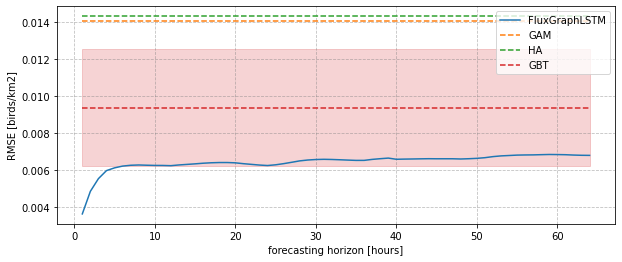

In [54]:
horizon = 64
fig, ax = plt.subplots(figsize=(10,4))
# for group, df in rmse_per_hour.groupby(['model', 'experiment']): 
for m, e in models.items():
    df = rmse_per_hour.query(f'model == "{m}" & experiment == "{e}"')
    if m in static_models:
        grouped = df.groupby('trial')
        df = grouped.aggregate(np.nanmean).reset_index()
        avg = np.repeat(df.rmse.mean(), horizon)
        std = np.repeat(df.rmse.std(), horizon)
        ls = '--'
    else:
        grouped = df.groupby(['horizon', 'trial']).rmse.aggregate(np.nanmean).reset_index()
        grouped = grouped.groupby('horizon')
        avg = grouped.rmse.aggregate(np.nanmean).values[-horizon:]
        std = grouped.rmse.aggregate(np.nanstd).values[-horizon:]
        ls = '-'
    line = ax.plot(range(1, horizon + 1), avg, ls=ls, label=m)
    ax.fill_between(range(1, horizon + 1), avg-std, avg+std, color=line[0].get_color(), alpha=0.2)
ax.legend(loc=1)
ax.set(xlabel='forecasting horizon [hours]', ylabel='RMSE [birds/km2]')
plt.grid(color='gray', linestyle='--', alpha=0.5);

## Spatial correlation of residuals

In [120]:
#m = 'FluxGraphLSTM'
res_corr = compute_residual_corr(results, radar_df, km2=True)

## Load Voronoi data

In [67]:
voronoi = gpd.read_file(osp.join(base_dir, 'data', 'preprocessed', f'1H_voronoi_ndummy={n_dummy}',
                                 'abm', season, str(year), 'voronoi.shp'))
radar_dict = voronoi.radar.to_dict()
radar_dict = {v: k for k, v in radar_dict.items()}

inner_radars = voronoi.query('boundary == 0').radar.values
boundary_idx = voronoi.query('boundary == 1').index.values

## Evaluate source/sink terms
1. Load simulated source/sink

In [85]:
#data_dir = osp.join(base_dir, 'data', 'raw', 'abm', 'fall', '2017')

dep = np.load(osp.join(data_dir, 'departing_birds.npy'))
land = np.load(osp.join(data_dir, 'landing_birds.npy'))

with open(osp.join(data_dir, 'time.pkl'), 'rb') as f:
    abm_time = pickle.load(f)
time_dict = {t: idx for idx, t in enumerate(abm_time)}

2. Load predicted source/sink

In [100]:
m = 'FluxGraphLSTM'
d = models[m]
result_dir = osp.join(base_dir, 'results', datasource, m, f'test_{year}', d)
print(result_dir)
results, cfg = load_results(result_dir, ext=ext, trials=trials)

/home/flipper/birdMigration/results/abm/FluxGraphLSTM/test_2017/final_evaluation_128_importance_sampling_new_tf09_3e7


3. Combine both into one dataframe and aggregate over the first 24h

In [101]:
def get_abm_data(data, datetime, radar):
    tidx = time_dict[pd.Timestamp(datetime)]
    ridx = radar_dict[radar]
    return data[tidx, ridx]

results['gt_source'] = results.apply(lambda row: get_abm_data(dep, row.datetime, row.radar), axis=1)
results['gt_sink'] = results.apply(lambda row: get_abm_data(land, row.datetime, row.radar), axis=1)

# only keep forecasts for observed radars
df = results[results.radar.isin(inner_radars)].dropna()

# aggregate over 24h
agg = df.query('horizon > 0 & horizon <= 24').groupby('seqID')
agg = agg.aggregate(np.sum).reset_index()

4. Plot simulated vs. predicted source terms, aggregated over a 24h forecasting horizon

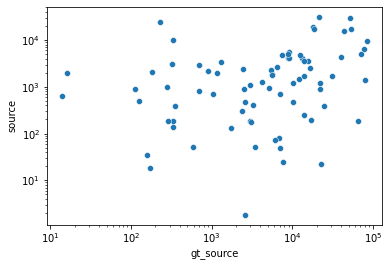

In [87]:
fig, ax = plt.subplots()
sb.scatterplot(x='gt_source', y='source', data=agg, ax=ax)
ax.set(xscale='log', yscale='log');

5. Plot simulated vs. predicted sink terms, aggregated over a 24h forecasting horizon

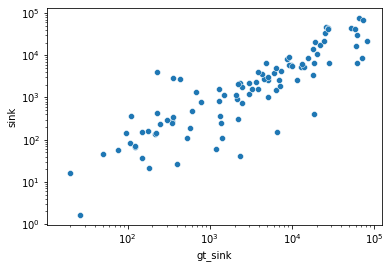

In [88]:
fig, ax = plt.subplots()
sb.scatterplot(x='gt_sink', y='sink', data=agg, ax=ax)
ax.set(xscale='log', yscale='log');

## Evaluate fluxes

2. Load simulated fluxes

In [89]:
gt_fluxes = np.load(osp.join(data_dir, 'outfluxes.npy'))

with open(osp.join(data_dir, 'time.pkl'), 'rb') as f:
    abm_time = pickle.load(f)
time_dict = {t: idx for idx, t in enumerate(abm_time)}

3. Load predicted fluxes

In [106]:
model_fluxes = load_model_fluxes(result_dir, ext=ext, trials=trials)

trial = 5
model_flux_t = np.stack([f.detach().numpy() for f in model_fluxes[trial].values()], axis=-1)
model_net_flux_t = model_flux_t - np.moveaxis(model_flux_t, 0, 1)
model_flux_per_seq_t = model_flux_per_seq_t = model_flux_t.sum(2)
model_net_flux_per_seq_t = model_flux_per_seq_t - np.moveaxis(model_flux_per_seq_t, 0, 1)

4. Bring simulated and predicted fluxes into same format

In [111]:
# rearange abm fluxes to match model fluxes
gt_flux_dict = {}
for group, df in results.groupby('seqID'):
    time = df.datetime.unique()
    gt_flux_dict[group] = np.stack([gt_fluxes[time_dict[pd.Timestamp(t)]] for t in time], axis=-1)

context = cfg['model']['context']
horizon = cfg['model']['test_horizon']
gt_flux = np.stack([f[..., context: context + horizon] for
            f in gt_flux_dict.values()], axis=-1)

# exclude "self-fluxes"
for i in range(gt_flux.shape[0]):
    np.fill_diagonal(gt_flux[i, i], np.nan)

# exclude "boundary to boundary" fluxes
for i, j in it.product(boundary_idx, repeat=2):
    gt_flux[i, j] = np.nan

gt_flux_per_seq = gt_flux.sum(2)
gt_net_flux = gt_flux - np.moveaxis(gt_flux, 0, 1)
gt_net_flux_per_seq = gt_flux_per_seq - np.moveaxis(gt_flux_per_seq, 0, 1)

5. Plot simulated vs. predicted fluxes

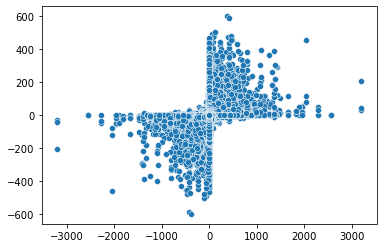

In [115]:
fig, ax = plt.subplots()
sb.scatterplot(x=gt_net_flux.flatten(), y=model_net_flux_t.flatten(), ax=ax);
#ax.set(xscale='log', yscale='log');

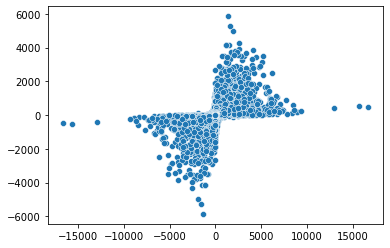

In [117]:
fig, ax = plt.subplots()
sb.scatterplot(x=gt_net_flux_per_seq.flatten(), y=model_net_flux_per_seq_t.flatten(), ax=ax);
#ax.set(xscale='symlog', yscale='symlog');